In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter

from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
import pandas as pd

processed_df = pd.read_csv('data_processed.csv')
processed_df.head()

,MBR_NO,TX_DTTM,TX_AMT,TX_TYPE,BIS_NM,REGULAR_YN,TX_INTERVAL
0,1303,2024-06-03 23:30:35,-923000.0,2,0,0,NaN
1,1303,2024-06-04 19:15:51,-920000.0,2,0,0,NaN
2,1349,2024-07-23 16:18:29,-644000.0,2,0,0,NaN
3,1349,2024-06-04 00:30:53,-489190.0,2,0,0,NaN
4,1303,2024-06-30 05:20:10,-13283.0,0,0,0,NaN


In [4]:
processed_df['TX_INTERVAL'].fillna(0, inplace=True)

/var/folders/dr/74f443cx0ljg_9kz1_q1ylv80000gn/T/ipykernel_38855/3515551195.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_df['TX_INTERVAL'].fillna(0, inplace=True)


In [5]:
processed_df_drop = processed_df.dropna()

In [6]:
processed_df_drop.head()

,MBR_NO,TX_DTTM,TX_AMT,TX_TYPE,BIS_NM,REGULAR_YN,TX_INTERVAL
0,1303,2024-06-03 23:30:35,-923000.0,2,0,0,0.0
1,1303,2024-06-04 19:15:51,-920000.0,2,0,0,0.0
2,1349,2024-07-23 16:18:29,-644000.0,2,0,0,0.0
3,1349,2024-06-04 00:30:53,-489190.0,2,0,0,0.0
4,1303,2024-06-30 05:20:10,-13283.0,0,0,0,0.0


In [7]:
from sklearn.preprocessing import StandardScaler

df_copy = processed_df_drop.copy()

scaler = StandardScaler()
df_copy['TX_AMT'] = scaler.fit_transform(df_copy[['TX_AMT']])

df_copy['TX_TIME'] = pd.to_datetime(df_copy['TX_DTTM']).dt.hour + pd.to_datetime(df_copy['TX_DTTM']).dt.minute / 60

In [8]:
cleaned_df = df_copy[['MBR_NO', 'TX_TIME','TX_AMT', 'TX_TYPE', 'BIS_NM', 'REGULAR_YN', 'TX_INTERVAL']].copy()

cleaned_df.head()

,MBR_NO,TX_TIME,TX_AMT,TX_TYPE,BIS_NM,REGULAR_YN,TX_INTERVAL
0,1303,23.500000,-8.849636,2,0,0,0.0
1,1303,19.250000,-8.821235,2,0,0,0.0
2,1349,16.300000,-6.208327,2,0,0,0.0
3,1349,0.500000,-4.742732,2,0,0,0.0
4,1303,5.333333,-0.237293,0,0,0,0.0


In [9]:
print(cleaned_df['REGULAR_YN'].value_counts())


REGULAR_YN
0    2500973
1       2060
Name: count, dtype: int64


### 불균형 확인

In [10]:
cleaned_df['REGULAR_YN'].value_counts()


REGULAR_YN
0    2500973
1       2060
Name: count, dtype: int64

In [11]:
import numpy as np

features = cleaned_df.values
labels = np.array(cleaned_df.pop('REGULAR_YN'))

print(features.shape)
print(labels.shape)

(2503033, 7)
(2503033,)


In [12]:
from sklearn.model_selection import train_test_split


# 훈련/임시 테스트 데이터 나누기
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.5, random_state=42, stratify=labels)

# 임시 테스트 데이터를 테스트/검증으로 나누기
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"훈련 데이터 크기: {X_train.shape}, 검증 데이터 크기: {X_val.shape}, 테스트 데이터 크기: {X_test.shape}")



훈련 데이터 크기: (1251516, 7), 검증 데이터 크기: (625758, 7), 테스트 데이터 크기: (625759, 7)


In [13]:
from collections import Counter

print(Counter(labels))
print(Counter(y_train))
print(Counter(y_val))
print(Counter(y_test))




Counter({0: 2500973, 1: 2060})
Counter({0: 1250486, 1: 1030})
Counter({0: 625243, 1: 515})
Counter({0: 625244, 1: 515})


In [14]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


### 모든 데이터를 활용해서 autoencoder 학습

Autoencoder의 encoder부분을 feature extractor로 이용

In [15]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization

# 입력 레이어
input_layer = Input(shape=(X_train.shape[1],))

# Encoder 부분
encoded = Dense(128, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.3)(encoded)

encoded = Dense(64, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.3)(encoded)

encoded_all = Dense(32, activation='relu', name="encoded_output")(encoded)

# Decoder 부분
decoded = Dense(64, activation='relu')(encoded_all)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.3)(decoded)

decoded = Dense(128, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.3)(decoded)

decoded_all = Dense(X_train.shape[1], activation='sigmoid')(decoded)

# Encoder와 Autoencoder 모델 생성
encoder_all = Model(input_layer, encoded_all, name="Encoder_Model")
autoencoder_all = Model(input_layer, decoded_all, name="Autoencoder_Model")

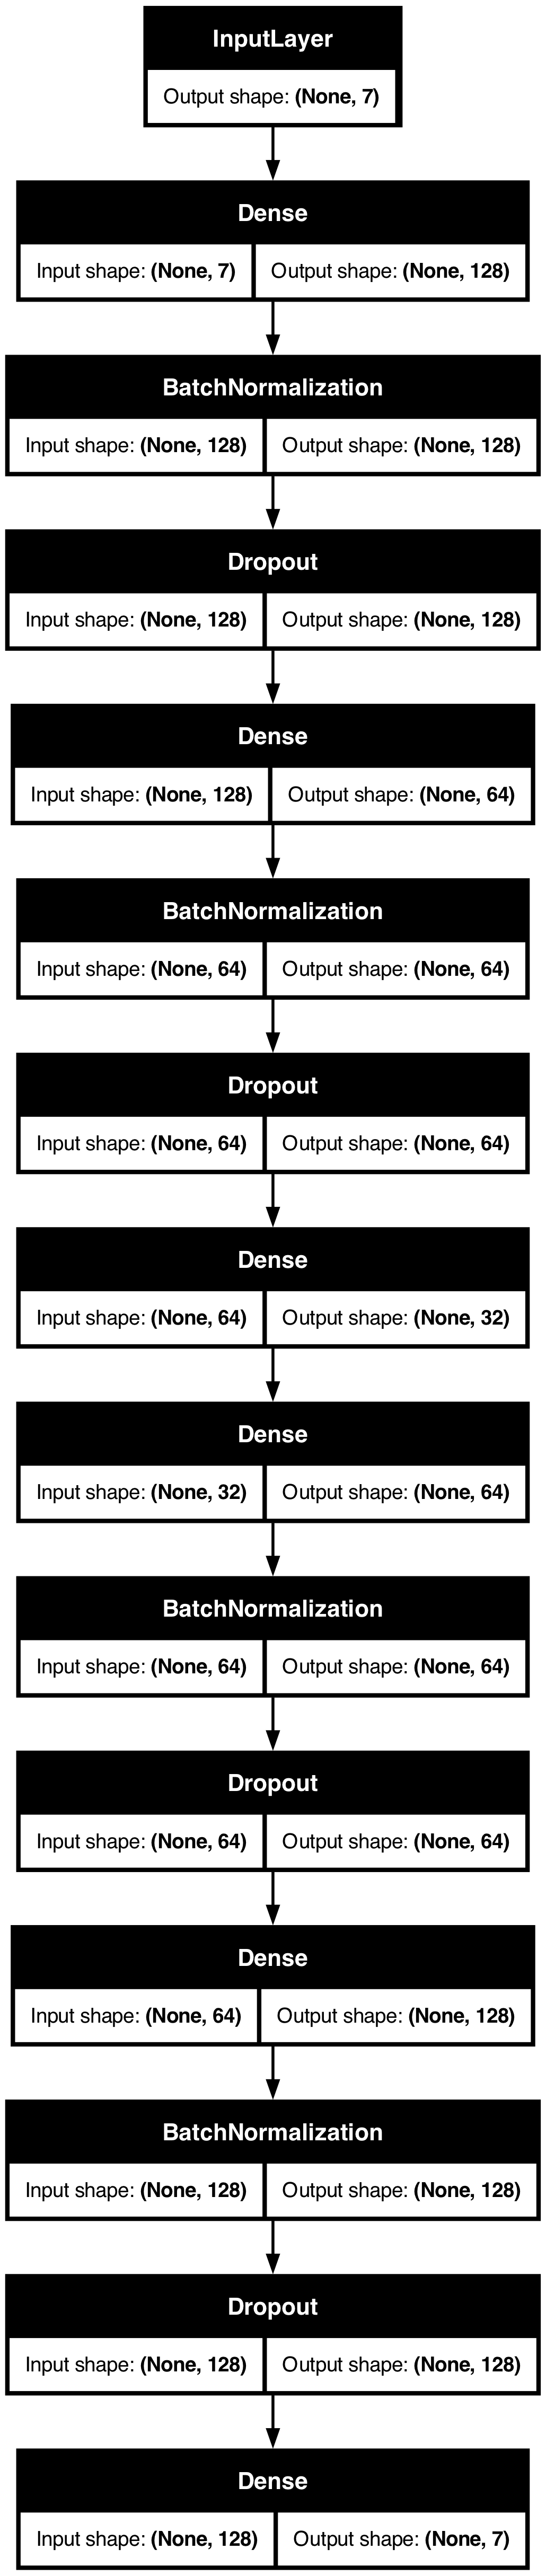

In [16]:
plot_model(autoencoder_all, show_shapes=True)

In [17]:
autoencoder_all.compile(optimizer='adam', loss='mse')

history = autoencoder_all.fit(X_train, X_train, epochs = 10,
                              batch_size=128, validation_data=(X_test, X_test))

Epoch 1/10
9778/9778 ━━━━━━━━━━━━━━━━━━━━ 78s 8ms/step - loss: 0.7535 - val_loss: 0.7145
Epoch 2/10
7089/9778 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.7215

KeyboardInterrupt: 

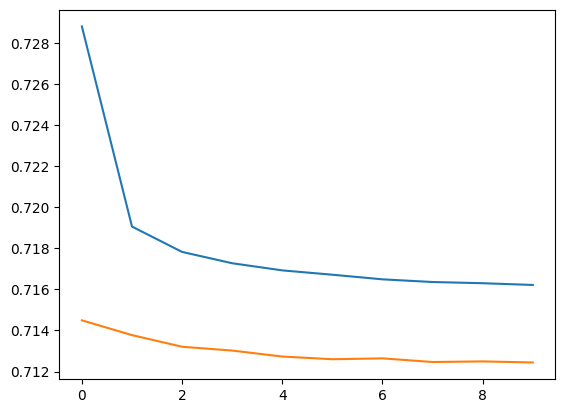

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

### KNN, SVC

train input으로 사용하기 위한 encoder output 출력

In [56]:
enc_all = encoder_all.predict(X_train)
enc_all.shape


39110/39110 ━━━━━━━━━━━━━━━━━━━━ 10s 248us/step


(1251516, 32)

encoder output을 feature로 사용하여 knn, svc 모델 학습

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

model_knn = KNeighborsClassifier(n_neighbors=5)
model_svc = SVC()

model_knn.fit(enc_all, y_train)
model_svc.fit(enc_all, y_train)

SVC()

In [58]:
enc_test = encoder_all.predict(X_test)

19555/19555 ━━━━━━━━━━━━━━━━━━━━ 5s 245us/step


In [59]:
predicted_svc = model_svc.predict(enc_test)
print(predicted_svc.shape)


(625759,)


In [60]:
predicted_knn = model_knn.predict(enc_test)
print(predicted_knn.shape)

(625759,)


### DNN 이진분류 모델

In [61]:
model_dnn = tf.keras.Sequential([
      tf.keras.layers.Dense(32, activation='relu', input_shape=(enc_all.shape[-1],)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='sigmoid'),
  ])

model_dnn.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss = 'binary_crossentropy', metrics=['accuracy'])

/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
history = model_dnn.fit(enc_all, y_train, epochs=30, batch_size=1024,
                    validation_data=(enc_test, y_test))

Epoch 1/30
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 2s 953us/step - accuracy: 0.9511 - loss: 0.1210 - val_accuracy: 1.0000 - val_loss: 3.5254e-07
Epoch 2/30
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 1.0000 - loss: 2.3058e-04 - val_accuracy: 1.0000 - val_loss: 4.4087e-09
Epoch 3/30
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - accuracy: 1.0000 - loss: 7.9777e-05 - val_accuracy: 1.0000 - val_loss: 5.1937e-10
Epoch 4/30
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step - accuracy: 1.0000 - loss: 2.7266e-05 - val_accuracy: 1.0000 - val_loss: 8.6064e-12
Epoch 5/30
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 1.0000 - loss: 1.2485e-05 - val_accuracy: 1.0000 - val_loss: 4.3930e-14
Epoch 6/30
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - accuracy: 1.0000 - loss: 6.2631e-06 - val_accuracy: 1.0000 - val_loss: 6.1908e-16
Epoch 7/30
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 1.0000 - loss: 4.6210e-06 - val_accuracy: 1.0000 - val_loss: 1.8590e-16
Epoch 8/30
1223/1223 ━━━

In [63]:
predicted_dnn = model_dnn.predict(enc_test)
print(predicted_dnn.shape)


19555/19555 ━━━━━━━━━━━━━━━━━━━━ 4s 211us/step
(625759, 1)


In [64]:
predicted_binary_dnn = (predicted_dnn > 0.5).astype(int)

f1 1.00
Precision 1.00
Recall 1.00


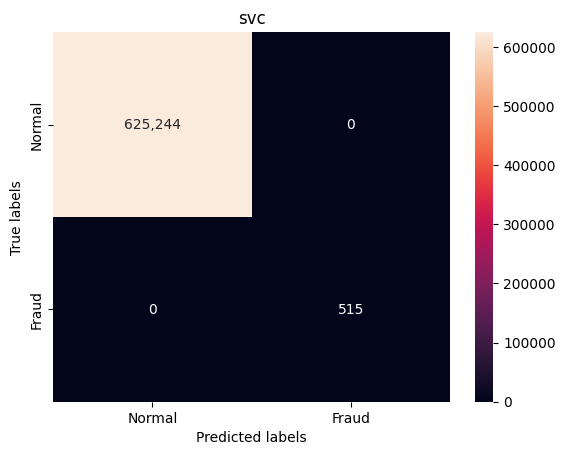

f1 1.00
Precision 1.00
Recall 1.00


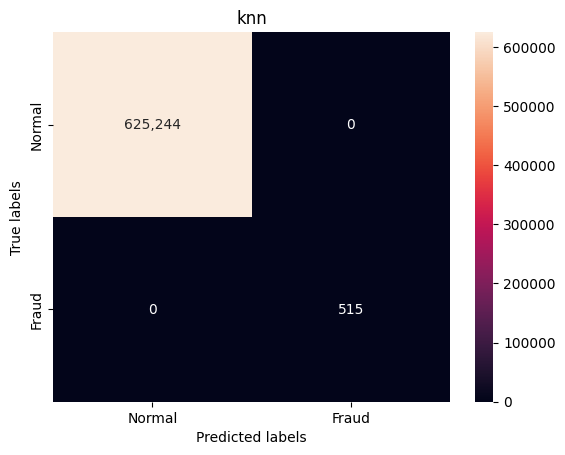

f1 1.00
Precision 1.00
Recall 1.00


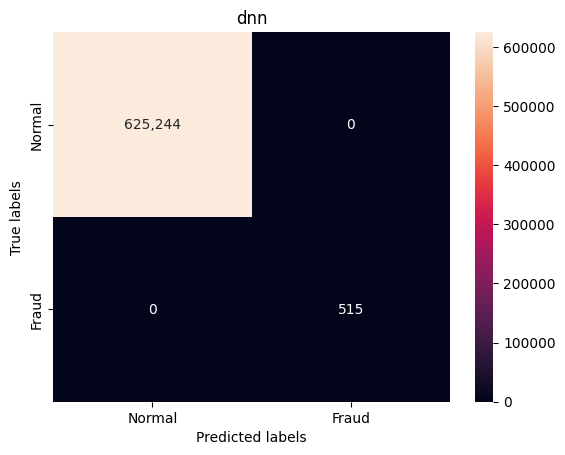

In [65]:
from sklearn.metrics import f1_score

for model, predicted in [("svc", predicted_svc),
                         ("knn", predicted_knn),
                         ("dnn", predicted_binary_dnn)]:

    # 정밀도(Precision)를 계산하여 출력합니다.
    print("f1 {:.2f}".format(f1_score(y_test, predicted)))
    print("Precision {:.2f}".format(precision_score(y_test, predicted)))
    # 재현율(Recall)을 계산하여 출력합니다.
    print("Recall {:.2f}".format(recall_score(y_test, predicted)))

    # 혼동 행렬(confusion matrix)을 계산합니다.
    cm = confusion_matrix(y_test, predicted)

    # 혼동 행렬을 히트맵으로 시각화합니다.
    ax = sns.heatmap(cm, annot=True, fmt=',')

    # x축 레이블을 설정합니다.
    ax.set_xlabel('Predicted labels')

    # y축 레이블을 설정합니다.
    ax.set_ylabel('True labels')

    # 그래프의 제목을 설정합니다. 제목은 모델의 이름입니다.
    ax.set_title(model)

    # x축 틱 레이블을 설정합니다.
    ax.xaxis.set_ticklabels(['Normal', 'Fraud'])

    # y축 틱 레이블을 설정합니다.
    ax.yaxis.set_ticklabels(['Normal', 'Fraud'])

    # 틱 위치를 설정합니다.
    ax.set(yticks=[0.5, 1.5], xticks=[0.5, 1.5])

    # 그래프를 화면에 표시합니다.
    plt.show()

In [66]:
# 교차검증

from sklearn.model_selection import cross_val_score

# 교차검증을 수행할 모델 리스트
models = [("svc", model_svc), ("knn", model_knn)]

# 각 모델에 대해 교차검증을 수행합니다.
for model_name, model in models:
    # 교차검증을 수행하고, 각 폴드의 점수를 저장합니다.
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    
    # 각 모델의 교차검증 점수를 출력합니다.
    print(f"{model_name} 교차검증 F1 점수: {scores}")
    print(f"{model_name} 평균 교차검증 F1 점수: {scores.mean():.2f}")


svc 교차검증 F1 점수: [0.99266504 1.         0.99756691 0.99512195 0.99756691]
svc 평균 교차검증 F1 점수: 1.00
knn 교차검증 F1 점수: [1. 1. 1. 1. 1.]
knn 평균 교차검증 F1 점수: 1.00


In [67]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import numpy as np

# 교차검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

# 각 폴드에 대해 교차검증 수행
for train_index, val_index in kf.split(X_train):
    # 데이터 분리
    X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    # 새 Keras 모델 생성
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # 모델 학습
    model.fit(X_fold_train, y_fold_train, epochs=10, batch_size=32, verbose=0)
    
    # 교차검증 점수 계산
    y_fold_pred = (model.predict(X_fold_val) > 0.5).astype(int)
    f1 = f1_score(y_fold_val, y_fold_pred)
    f1_scores.append(f1)

print(f"DNN 교차검증 F1 점수: {f1_scores}")
print(f"DNN 평균 교차검증 F1 점수: {np.mean(f1_scores):.2f}")


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7822/7822 ━━━━━━━━━━━━━━━━━━━━ 2s 219us/step


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7822/7822 ━━━━━━━━━━━━━━━━━━━━ 2s 216us/step


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7822/7822 ━━━━━━━━━━━━━━━━━━━━ 2s 222us/step


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7822/7822 ━━━━━━━━━━━━━━━━━━━━ 2s 217us/step


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7822/7822 ━━━━━━━━━━━━━━━━━━━━ 2s 216us/step
DNN 교차검증 F1 점수: [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
DNN 평균 교차검증 F1 점수: 1.00


In [68]:
def create_dnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(32,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [69]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

# Stratified K-Fold 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

# 교차검증 수행
for train_idx, val_idx in skf.split(enc_all, y_train):
    X_train_fold, X_val_fold = enc_all[train_idx], enc_all[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # 새로운 DNN 모델 생성
    model = create_dnn_model()
    
    # 모델 학습
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)
    
    # 예측 및 F1 Score 계산
    y_pred = model.predict(X_val_fold)
    y_pred_binary = (y_pred > 0.5).astype(int)
    f1 = f1_score(y_val_fold, y_pred_binary)
    f1_scores.append(f1)

# 결과 출력
print("F1 Scores for each fold:", f1_scores)
print("Mean F1 Score:", np.mean(f1_scores))


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7822/7822 ━━━━━━━━━━━━━━━━━━━━ 2s 209us/step


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7822/7822 ━━━━━━━━━━━━━━━━━━━━ 2s 213us/step


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7822/7822 ━━━━━━━━━━━━━━━━━━━━ 2s 213us/step


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7822/7822 ━━━━━━━━━━━━━━━━━━━━ 2s 214us/step


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7822/7822 ━━━━━━━━━━━━━━━━━━━━ 2s 214us/step
F1 Scores for each fold: [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
Mean F1 Score: 1.0


In [70]:
from sklearn.model_selection import StratifiedKFold

# 교차검증 수행
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    model = model_dnn()
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)
    
    y_pred = model.predict(X_val_fold)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    f1 = f1_score(y_val_fold, y_pred_binary)
    f1_scores.append(f1)

print("F1 Scores for each fold:", f1_scores)
print("Mean F1 Score:", np.mean(f1_scores))

TypeError: missing a required argument: 'inputs'

In [77]:
print(y_test.shape)
print(y_val.shape)
print(y_train.shape)
print(predicted_svc.shape)
print(predicted_knn.shape)
print(predicted_dnn.shape)


(625759,)
(625758,)
(1251516,)
(625759,)
(625759,)
(625759, 1)


In [82]:
predicted_svc_val = predicted_svc[:-1]
predicted_knn_val = predicted_knn[:-1]
predicted_dnn_val = predicted_dnn[:-1]
predicted_binary_dnn_val = predicted_binary_dnn[:-1]

Precision 0.00
Recall 0.00


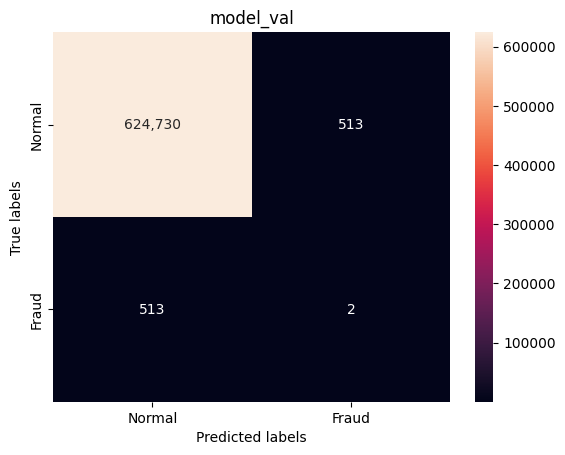

Precision 0.00
Recall 0.00


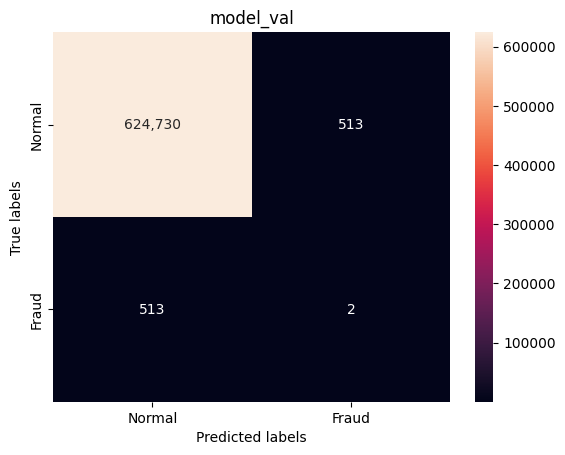

Precision 0.00
Recall 0.00


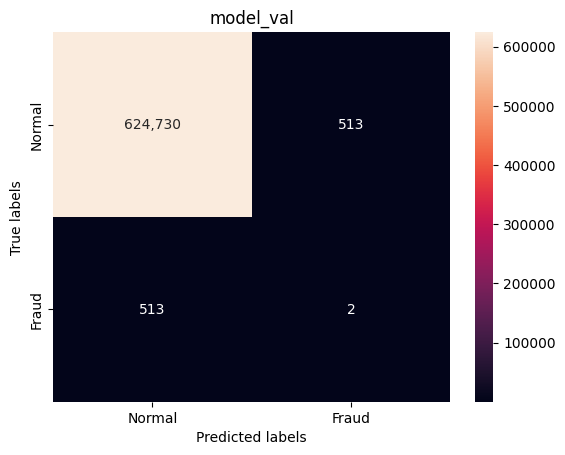

In [83]:
from sklearn.metrics import f1_score

for model, predicted in [("svc", predicted_svc_val),
                         ("knn", predicted_knn_val),
                         ("dnn", predicted_binary_dnn_val)]:

    # 정밀도(Precision)를 계산하여 출력합니다.
    # print("f1 {:.2f}".format(f1_score(y_val, predicted)))
    print("Precision {:.2f}".format(precision_score(y_val, predicted)))
    # 재현율(Recall)을 계산하여 출력합니다.
    print("Recall {:.2f}".format(recall_score(y_val, predicted)))

    # 혼동 행렬(confusion matrix)을 계산합니다.
    cm = confusion_matrix(y_val, predicted)

    # 혼동 행렬을 히트맵으로 시각화합니다.
    ax = sns.heatmap(cm, annot=True, fmt=',')

    # x축 레이블을 설정합니다.
    ax.set_xlabel('Predicted labels')
    
    # y축 레이블을 설정합니다.
    ax.set_ylabel('True labels')

    # 그래프의 제목을 설정합니다. 제목은 모델의 이름입니다.
    ax.set_title("model_val")

    # x축 틱 레이블을 설정합니다.
    ax.xaxis.set_ticklabels(['Normal', 'Fraud'])

    # y축 틱 레이블을 설정합니다.
    ax.yaxis.set_ticklabels(['Normal', 'Fraud'])

    # 틱 위치를 설정합니다.
    ax.set(yticks=[0.5, 1.5], xticks=[0.5, 1.5])

    # 그래프를 화면에 표시합니다.
    plt.show()

In [84]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization

# 입력 레이어
input_layer = Input(shape=(X_train.shape[1],))

encoded = Dense(128, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.3)(encoded)

encoded_all = Dense(32, activation='relu', name="encoded_output")(encoded)

# Decoder 부분
decoded = Dense(64, activation='relu')(encoded_all)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.3)(decoded)

decoded_all = Dense(X_train.shape[1], activation='sigmoid')(decoded)

# Encoder와 Autoencoder 모델 생성
encoder_all = Model(input_layer, encoded_all, name="Encoder_Model")
autoencoder_all = Model(input_layer, decoded_all, name="Autoencoder_Model")

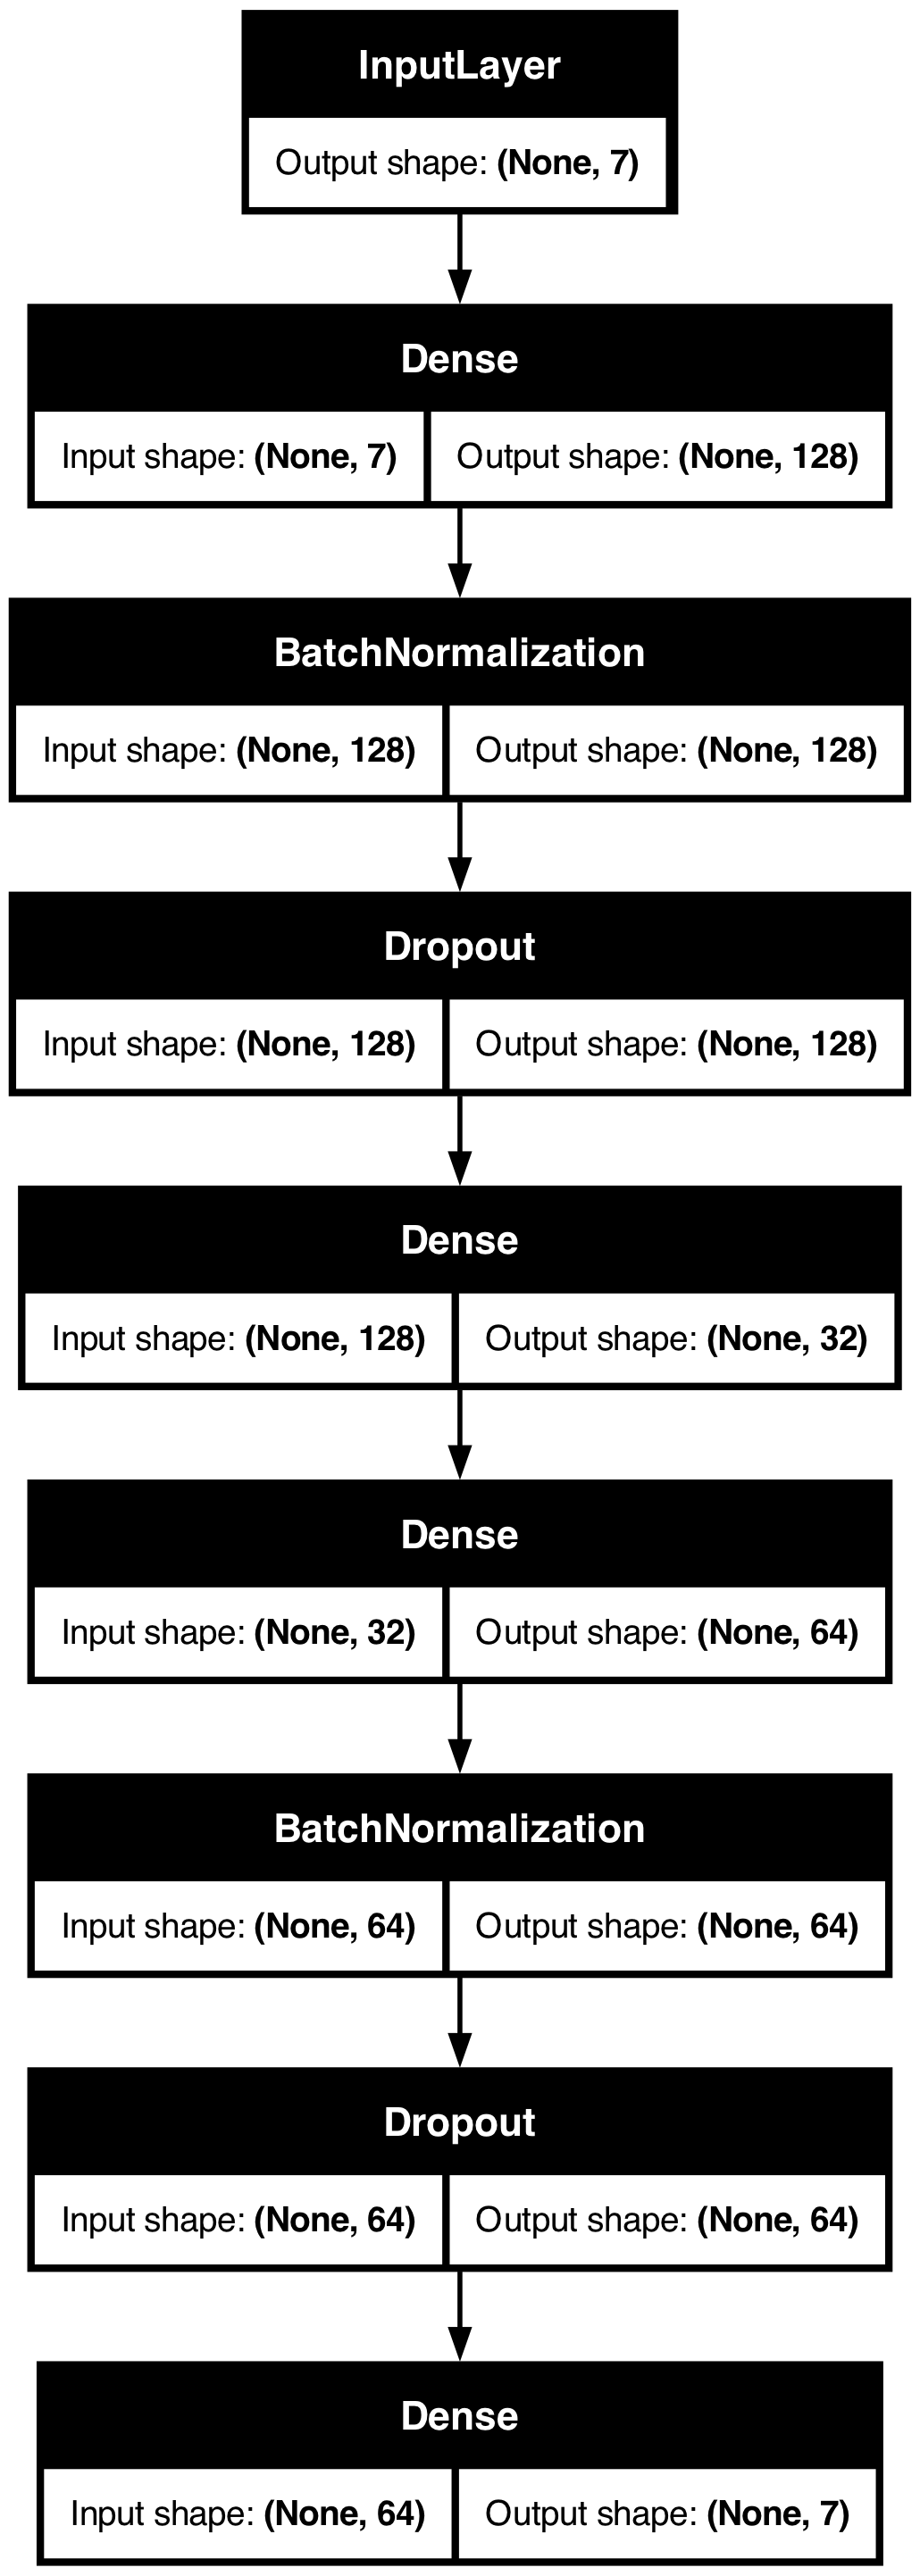

In [85]:
plot_model(autoencoder_all, show_shapes=True)

In [1]:
from sklearn.metrics import precision_recall_curve, auc

# Precision-Recall Curve 계산
precision_autoencoder, recall_autoencoder, _ = precision_recall_curve(y_test, predicted_dnn)

# Precision-Recall AUC 계산
pr_auc = auc(recall_autoencoder, precision_autoencoder)

print(f"Precision-Recall AUC: {pr_auc:.4f}")

NameError: name 'y_test' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(recall_autoencoder, precision_autoencoder, label=f'PR AUC = {pr_auc:.4f}', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()
